# Appendix: Synapses

## Synapse models

### AMPA

In [1]:
import brainpy as bp


class AMPA(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, t, TT, alpha, beta):
    ds = alpha * TT * (1 - s) - beta * s
    return ds

  def __init__(self, pre, post, conn, alpha=0.98, beta=0.18, T=0.5,
               T_duration=0.5, **kwargs):
    # parameters
    self.alpha = alpha
    self.beta = beta
    self.T = T
    self.T_duration = T_duration

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)
    self.t_last_pre_spike = -1e7 * bp.ops.ones(self.size)

    self.int_s = bp.odeint(f=self.derivative, method='exponential_euler')
    super(AMPA, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]

      if self.pre.spike[pre_id]:
        self.t_last_pre_spike[pre_id] = _t
      TT = ((_t - self.t_last_pre_spike[pre_id])
            < self.T_duration) * self.T
      self.s[i] = self.int_s(self.s[i], _t, TT, self.alpha, self.beta)


In [2]:
import brainmodels as bm

bp.backend.set(backend='numba', dt=0.1)
bm.set_backend(backend='numba')

def run_syn(syn_model, **kwargs):
  neu1 = bm.neurons.LIF(2, monitors=['V'])
  neu2 = bm.neurons.LIF(3, monitors=['V'])

  syn = syn_model(pre=neu1, post=neu2, conn=bp.connect.All2All(),
                  monitors=['s'], **kwargs)

  net = bp.Network(neu1, syn, neu2)
  net.run(30., inputs=(neu1, 'input', 35.))
  bp.visualize.line_plot(net.ts, syn.mon.s, ylabel='s', show=True)

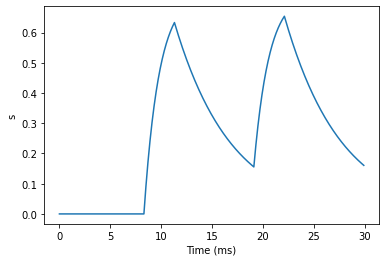

In [3]:
run_syn(AMPA, T_duration=3.)

### NMDA

In [4]:
class NMDA(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, x, t, tau_rise, tau_decay, a):
    dsdt = -s / tau_decay + a * x * (1 - s)
    dxdt = -x / tau_rise
    return dsdt, dxdt

  def __init__(self, pre, post, conn, delay=0., g_max=0.15, E=0., cc_Mg=1.2,
               alpha=0.062, beta=3.57, tau=100, a=0.5, tau_rise=2., **kwargs):
    # parameters
    self.g_max = g_max
    self.E = E
    self.alpha = alpha
    self.beta = beta
    self.cc_Mg = cc_Mg
    self.tau = tau
    self.tau_rise = tau_rise
    self.a = a
    self.delay = delay

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)
    self.x = bp.ops.zeros(self.size)
    self.g = self.register_constant_delay('g', size=self.size,
                                          delay_time=delay)

    self.integral = bp.odeint(f=self.derivative, method='rk4')

    super(NMDA, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]

      self.x[i] += self.pre.spike[pre_id]
      self.s[i], self.x[i] = self.integral(self.s[i], self.x[i], _t,
                                           self.tau_rise, self.tau,
                                           self.a)

      # output
      g_inf_exp = bp.ops.exp(-self.alpha * self.post.V[post_id])
      g_inf = 1 + g_inf_exp * self.cc_Mg / self.beta

      self.g.push(i, self.g_max * self.s[i] / g_inf)

      I_syn = self.g.pull(i) * (self.post.V[post_id] - self.E)
      self.post.input[post_id] -= I_syn

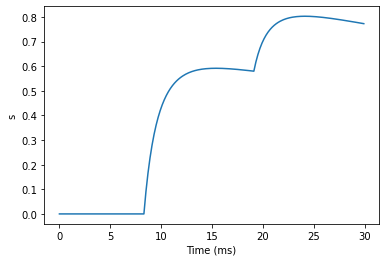

In [5]:
run_syn(NMDA)

### GABA_b

In [6]:
class GABAb(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(R, G, t, k3, TT, k4, k1, k2):
    dRdt = k3 * TT * (1 - R) - k4 * R
    dGdt = k1 * R - k2 * G
    return dRdt, dGdt

  def __init__(self, pre, post, conn, delay=0., g_max=0.02, E=-95.,
               k1=0.18, k2=0.034, k3=0.09, k4=0.0012, kd=100., T=0.5,
               T_duration=0.3, **kwargs):
    # params
    self.g_max = g_max
    self.E = E
    self.k1 = k1
    self.k2 = k2
    self.k3 = k3
    self.k4 = k4
    self.kd = kd
    self.T = T
    self.T_duration = T_duration

    # conns
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # data
    self.R = bp.ops.zeros(self.size)
    self.G = bp.ops.zeros(self.size)
    self.t_last_pre_spike = bp.ops.ones(self.size) * -1e7
    self.s = bp.ops.zeros(self.size)
    self.g = self.register_constant_delay('g', size=self.size,
                                          delay_time=delay)

    self.integral = bp.odeint(f=self.derivative, method='rk4')
    super(GABAb, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]

      if self.pre.spike[pre_id]:
        self.t_last_pre_spike[i] = _t
      TT = ((_t - self.t_last_pre_spike[i]) < self.T_duration) * self.T

      self.R[i], G = self.integral(self.R[i], self.G[i], _t, self.k3,
                                   TT, self.k4, self.k1, self.k2)
      self.s[i] = G ** 4 / (G ** 4 + self.kd)
      self.G[i] = G

      self.g.push(i, self.g_max * self.s[i])
      I_syn = self.g.pull(i) * (self.post.V[post_id] - self.E)
      self.post.input[post_id] -= I_syn

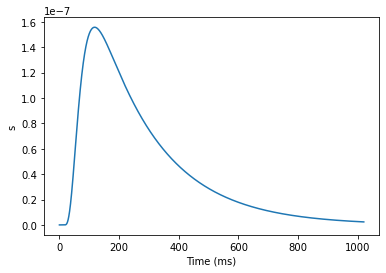

In [7]:
neu1 = bm.neurons.LIF(2, monitors=['V'])
neu2 = bm.neurons.LIF(3, monitors=['V'])
syn = GABAb(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['s'])
net = bp.Network(neu1, syn, neu2)

# input
I, dur = bp.inputs.constant_current([(25, 20), (0, 1000)])
net.run(dur, inputs=(neu1, 'input', I))

bp.visualize.line_plot(net.ts, syn.mon.s, ylabel='s', show=True)

### Differences of two exponentials

In [8]:
class Two_exponentials(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, x, t, tau1, tau2):
    dxdt = (-(tau1 + tau2) * x - s) / (tau1 * tau2)
    dsdt = x
    return dsdt, dxdt

  def __init__(self, pre, post, conn, tau1=1.0, tau2=3.0, **kwargs):
    # parameters
    self.tau1 = tau1
    self.tau2 = tau2

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)
    self.x = bp.ops.zeros(self.size)

    self.integral = bp.odeint(f=self.derivative, method='rk4')

    super(Two_exponentials, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]

      self.s[i], self.x[i] = self.integral(self.s[i], self.x[i], _t,
                                           self.tau1, self.tau2)
      self.x[i] += self.pre.spike[pre_id]


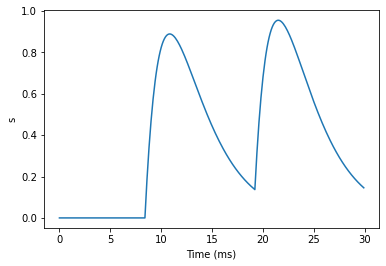

In [9]:
run_syn(Two_exponentials, tau1=2.)

### Alpha

In [10]:
class Alpha(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, x, t, tau):
    dxdt = (-2 * tau * x - s) / (tau ** 2)
    dsdt = x
    return dsdt, dxdt

  def __init__(self, pre, post, conn, tau=3.0, **kwargs):
    # parameters
    self.tau = tau

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)
    self.x = bp.ops.zeros(self.size)

    self.integral = bp.odeint(f=self.derivative, method='rk4')

    super(Alpha, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]

      self.s[i], self.x[i] = self.integral(self.s[i], self.x[i], _t,
                                           self.tau)
      self.x[i] += self.pre.spike[pre_id]

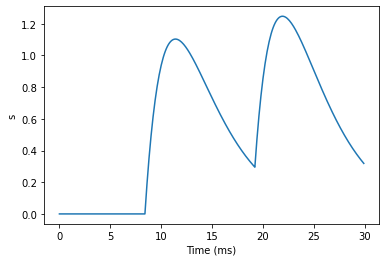

In [11]:
run_syn(Alpha)

### Single exponential decay

In [12]:
class Exponential(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, t, tau):
    ds = -s / tau
    return ds

  def __init__(self, pre, post, conn, tau=8.0, **kwargs):
    # parameters
    self.tau = tau

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)

    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

    super(Exponential, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]

      self.s[i] = self.integral(self.s[i], _t, self.tau)
      self.s[i] += self.pre.spike[pre_id]

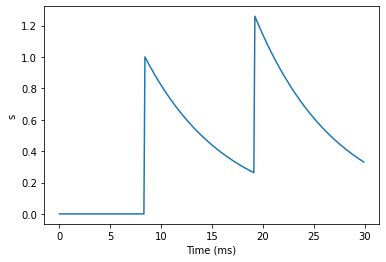

In [13]:
run_syn(Exponential)

### Voltage jump

In [14]:
class Voltage_jump(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  def __init__(self, pre, post, conn, **kwargs):
    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)

    super(Voltage_jump, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]
      self.s[i] = self.pre.spike[pre_id]

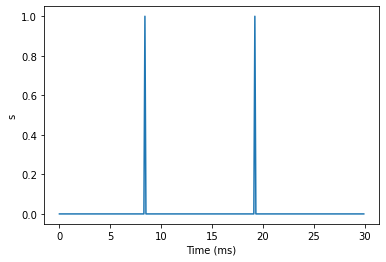

In [15]:
run_syn(Voltage_jump)

### Gap junction

In [16]:
class Gap_junction(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  def __init__(self, pre, post, conn, delay=0., k_spikelet=0.1,
               post_refractory=False, **kwargs):
    self.delay = delay
    self.k_spikelet = k_spikelet
    self.post_has_refractory = post_refractory

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.w = bp.ops.ones(self.size)
    self.spikelet = self.register_constant_delay('spikelet', size=self.size,
                                                 delay_time=self.delay)

    super(Gap_junction, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]

      self.post.input[post_id] += self.w[i] * (self.pre.V[pre_id] -
                                               self.post.V[post_id])

      self.spikelet.push(i, self.w[i] * self.k_spikelet *
                         self.pre.spike[pre_id])

      out = self.spikelet.pull(i)
      if self.post_has_refractory:
        self.post.V[post_id] += out * (1. - self.post.refractory[post_id])
      else:
        self.post.V[post_id] += out

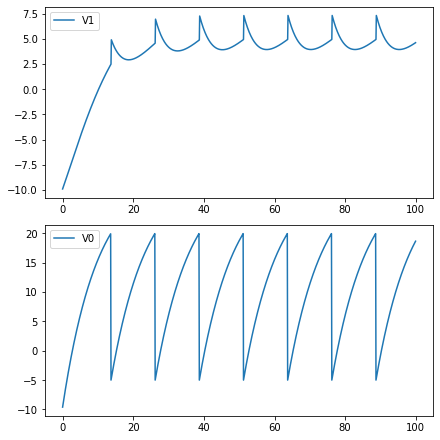

In [17]:
import matplotlib.pyplot as plt

neu0 = bm.neurons.LIF(1, monitors=['V'], t_refractory=0)
neu0.V = bp.ops.ones(neu0.V.shape) * -10.
neu1 = bm.neurons.LIF(1, monitors=['V'], t_refractory=0)
neu1.V = bp.ops.ones(neu1.V.shape) * -10.
syn = Gap_junction(pre=neu0, post=neu1, conn=bp.connect.All2All(),
                   k_spikelet=5.)
syn.w = bp.ops.ones(syn.w.shape) * .5

net = bp.Network(neu0, neu1, syn)
net.run(100., inputs=(neu0, 'input', 30.))

fig, gs = bp.visualize.get_figure(row_num=2, col_num=1, )

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, neu0.mon.V[:, 0], label='V0')
plt.legend()

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V[:, 0], label='V1')
plt.legend()
plt.show()

## Synaptic plasticity

### STP

In [18]:
class STP(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, u, x, t, tau, tau_d, tau_f):
    dsdt = -s / tau
    dudt = - u / tau_f
    dxdt = (1 - x) / tau_d
    return dsdt, dudt, dxdt

  def __init__(self, pre, post, conn, delay=0., U=0.15, tau_f=1500.,
               tau_d=200., tau=8., **kwargs):
    # parameters
    self.tau_d = tau_d
    self.tau_f = tau_f
    self.tau = tau
    self.U = U
    self.delay = delay

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)
    self.x = bp.ops.ones(self.size)
    self.u = bp.ops.zeros(self.size)
    self.w = bp.ops.ones(self.size)
    self.I_syn = self.register_constant_delay('I_syn', size=self.size,
                                              delay_time=delay)

    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

    super(STP, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]

      self.s[i], u, x = self.integral(self.s[i], self.u[i], self.x[i], _t,
                                      self.tau, self.tau_d, self.tau_f)

      if self.pre.spike[pre_id] > 0:
        u += self.U * (1 - self.u[i])
        self.s[i] += self.w[i] * u * self.x[i]
        x -= u * self.x[i]
      self.u[i] = u
      self.x[i] = x

      # output
      post_id = self.post_ids[i]
      self.I_syn.push(i, self.s[i])
      self.post.input[post_id] += self.I_syn.pull(i)

In [19]:
def run_stp(**kwargs):
    neu1 = bm.neurons.LIF(1, monitors=['V'])
    neu2 = bm.neurons.LIF(1, monitors=['V'])

    syn = STP(pre=neu1, post=neu2, conn=bp.connect.All2All(),
              monitors=['s', 'u', 'x'], **kwargs)
    net = bp.Network(neu1, syn, neu2)
    net.run(100., inputs=(neu1, 'input', 28.))

    # plot
    fig, gs = bp.visualize.get_figure(2, 1, 3, 7)

    fig.add_subplot(gs[0, 0])
    plt.plot(net.ts, syn.mon.u[:, 0], label='u')
    plt.plot(net.ts, syn.mon.x[:, 0], label='x')
    plt.legend()

    fig.add_subplot(gs[1, 0])
    plt.plot(net.ts, syn.mon.s[:, 0], label='s')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.show()

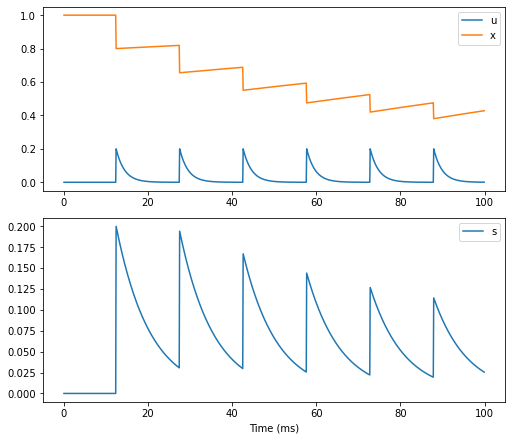

In [20]:
run_stp(U=0.2, tau_d=150., tau_f=2.)

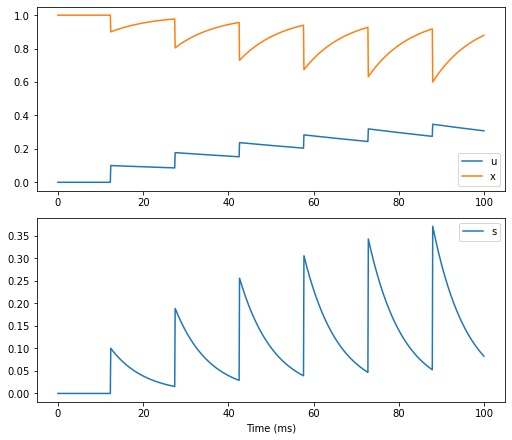

In [21]:
run_stp(U=0.1, tau_d=10, tau_f=100.)

## STDP

In [22]:
class STDP(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, A_s, A_t, t, tau, tau_s, tau_t):
    dsdt = -s / tau
    dAsdt = - A_s / tau_s
    dAtdt = - A_t / tau_t
    return dsdt, dAsdt, dAtdt

  def __init__(self, pre, post, conn, delay=0., delta_A_s=0.5,
               delta_A_t=0.5, w_min=0., w_max=20., tau_s=10., tau_t=10.,
               tau=10., **kwargs):
    # parameters
    self.tau_s = tau_s
    self.tau_t = tau_t
    self.tau = tau
    self.delta_A_s = delta_A_s
    self.delta_A_t = delta_A_t
    self.w_min = w_min
    self.w_max = w_max
    self.delay = delay

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = self.conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.size)
    self.A_s = bp.ops.zeros(self.size)
    self.A_t = bp.ops.zeros(self.size)
    self.w = bp.ops.ones(self.size) * 1.
    self.I_syn = self.register_constant_delay('I_syn', size=self.size,
                                              delay_time=delay)
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

    super(STDP, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]

      self.s[i], A_s, A_t = self.integral(self.s[i], self.A_s[i],
                                          self.A_t[i], _t, self.tau,
                                          self.tau_s, self.tau_t)

      w = self.w[i]
      if self.pre.spike[pre_id] > 0:
        self.s[i] += w
        A_s += self.delta_A_s
        w -= A_t

      if self.post.spike[post_id] > 0:
        A_t += self.delta_A_t
        w += A_s

      self.A_s[i] = A_s
      self.A_t[i] = A_t

      self.w[i] = bp.ops.clip(w, self.w_min, self.w_max)

      # output
      self.I_syn.push(i, self.s[i])
      self.post.input[post_id] += self.I_syn.pull(i)

In [23]:
duration = 300.
(I_pre, _) = bp.inputs.constant_current([(0, 5), (30, 15),   # pre at 5ms
                 (0, 15), (30, 15),  
                 (0, 15), (30, 15),
                 (0, 98), (30, 15),  # switch order: t_interval=98ms
                 (0, 15), (30, 15),
                 (0, 15), (30, 15),
                 (0, duration-155-98)])
(I_post, _) = bp.inputs.constant_current([(0, 10), (30, 15), # post at 10 
                  (0, 15), (30, 15),
                  (0, 15), (30, 15),
                  (0, 90), (30, 15), # switch order: t_interval=98-8=90(ms)
                  (0, 15), (30, 15),
                  (0, 15), (30, 15),
                  (0, duration-160-90)])

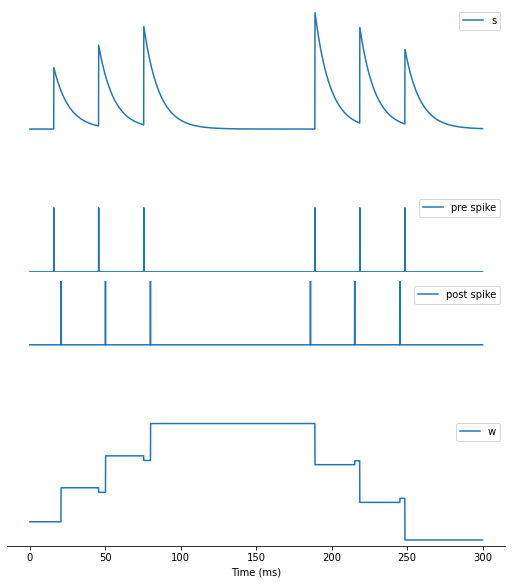

In [24]:
pre = bm.neurons.LIF(1, monitors=['spike'])
post = bm.neurons.LIF(1, monitors=['spike'])

syn = STDP(pre=pre, post=post, conn=bp.connect.All2All(),
           monitors=['s', 'w'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=[(pre, 'input', I_pre), (post, 'input', I_post)])

# plot
fig, gs = bp.visualize.get_figure(4, 1, 2, 7)

def hide_spines(my_ax):
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    my_ax.spines['left'].set_visible(False)
    my_ax.spines['right'].set_visible(False)
    my_ax.spines['bottom'].set_visible(False)
    my_ax.spines['top'].set_visible(False)

ax=fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label="s")
hide_spines(ax)

ax1=fig.add_subplot(gs[1, 0])
plt.plot(net.ts, pre.mon.spike[:, 0], label="pre spike")
plt.ylim(0, 2)
hide_spines(ax1)
plt.legend(loc = 'center right')

ax2=fig.add_subplot(gs[2, 0])
plt.plot(net.ts, post.mon.spike[:, 0], label="post spike")
plt.ylim(-1, 1)
hide_spines(ax2)

ax3=fig.add_subplot(gs[3, 0])
plt.plot(net.ts, syn.mon.w[:, 0], label="w")
plt.legend()
# hide spines
plt.yticks([])
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.xlabel('Time (ms)')
plt.show()

## Oja's rule

In [25]:
import numpy as np

bp.backend.set(backend='numpy', dt=0.1)


class Oja(bp.TwoEndConn):
  target_backend = 'numpy'

  @staticmethod
  def derivative(w, t, gamma, r_pre, r_post):
    dwdt = gamma * (r_post * r_pre - r_post * r_post * w)
    return dwdt

  def __init__(self, pre, post, conn, gamma=.005, w_max=1., w_min=0., **kwargs):
    # params
    self.gamma = gamma
    self.w_max = w_max
    self.w_min = w_min
    # no delay in firing rate models

    # conns
    self.conn = conn(pre.size, post.size)
    self.conn_mat = conn.requires('conn_mat')
    self.size = bp.ops.shape(self.conn_mat)

    # data
    self.w = bp.ops.ones(self.size) * 0.05

    self.integral = bp.odeint(f=self.derivative)
    super(Oja, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    w = self.conn_mat * self.w
    self.post.r = np.sum(w.T * self.pre.r, axis=1)

    # resize to matrix
    dim = self.size
    r_post = np.vstack((self.post.r,) * dim[0])
    r_pre = np.vstack((self.pre.r,) * dim[1]).T

    self.w = self.integral(w, _t, self.gamma, r_pre, r_post)

In [26]:
class neu(bp.NeuGroup):
  target_backend = 'numpy'

  def __init__(self, size, **kwargs):
    self.r = bp.ops.zeros(size)
    super(neu, self).__init__(size=size, **kwargs)

  def update(self, _t):
    self.r = self.r

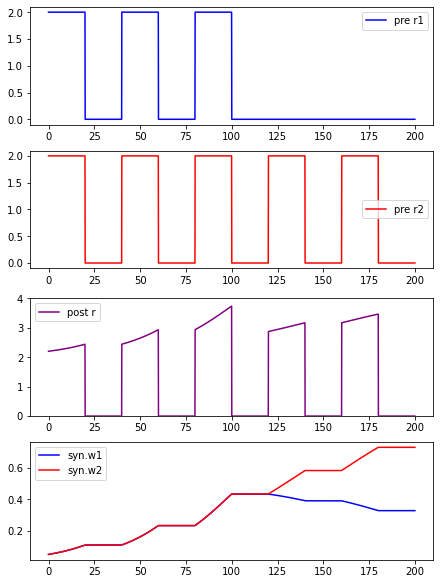

In [27]:
# create input
current1, _ = bp.inputs.constant_current([(2., 20.), (0., 20.)] * 3 +
                                         [(0., 20.), (0., 20.)] * 2)
current2, _ = bp.inputs.constant_current([(2., 20.), (0., 20.)] * 5)
current3, _ = bp.inputs.constant_current([(2., 20.), (0., 20.)] * 5)
current_pre = np.vstack((current1, current2))
current_post = np.vstack((current3, current3))

# simulate
neu_pre = neu(2, monitors=['r'])
neu_post = neu(2, monitors=['r'])
syn = Oja(pre=neu_pre, post=neu_post, conn=bp.connect.All2All(), monitors=['w'])
net = bp.Network(neu_pre, syn, neu_post)
net.run(duration=200., inputs=[(neu_pre, 'r', current_pre.T, '='),
                               (neu_post, 'r', current_post.T)])

# plot
fig, gs = bp.visualize.get_figure(4, 1, 2, 6)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu_pre.mon.r[:, 0], 'b', label='pre r1')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, neu_pre.mon.r[:, 1], 'r', label='pre r2')
plt.legend()

fig.add_subplot(gs[2, 0])
plt.plot(net.ts, neu_post.mon.r[:, 0], color='purple', label='post r')
plt.ylim([0, 4])
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.ts, syn.mon.w[:, 0, 0], 'b', label='syn.w1')
plt.plot(net.ts, syn.mon.w[:, 1, 0], 'r', label='syn.w2')
plt.legend()
plt.show()

### BCM rule

In [28]:
class BCM(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(w, t, lr, r_pre, r_post, r_th):
    dwdt = lr * r_post * (r_post - r_th) * r_pre
    return dwdt

  def __init__(self, pre, post, conn, lr=0.005, w_max=1., w_min=0., **kwargs):
    # parameters
    self.lr = lr
    self.w_max = w_max
    self.w_min = w_min
    self.dt = bp.backend.get_dt()

    # connections
    self.conn = conn(pre.size, post.size)
    self.conn_mat = conn.requires('conn_mat')
    self.size = bp.ops.shape(self.conn_mat)

    # variables
    self.w = bp.ops.ones(self.size) * .5
    self.sum_post_r = bp.ops.zeros(post.size[0])
    self.r_th = bp.ops.zeros(post.size[0])

    self.int_w = bp.odeint(f=self.derivative, method='rk4')

    super(BCM, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    # update threshold
    self.sum_post_r += self.post.r
    r_th = self.sum_post_r / (_t / self.dt + 1)
    self.r_th = r_th

    # resize to matrix
    w = self.w * self.conn_mat
    dim = self.size
    r_th = np.vstack((r_th,) * dim[0])
    r_post = np.vstack((self.post.r,) * dim[0])
    r_pre = np.vstack((self.pre.r,) * dim[1]).T

    # update w
    w = self.int_w(w, _t, self.lr, r_pre, r_post, r_th)
    self.w = np.clip(w, self.w_min, self.w_max)

    # output
    self.post.r = np.sum(w.T * self.pre.r, axis=1)

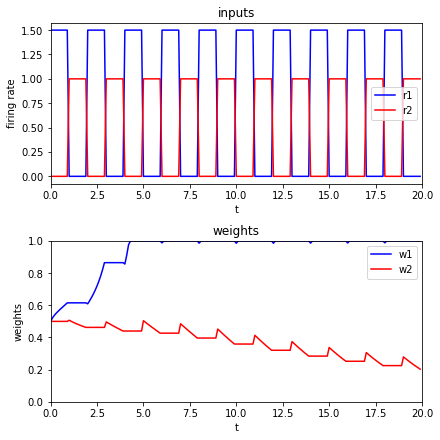

In [29]:
# create input
group1, _ = bp.inputs.constant_current(([1.5, 1],
                                        [0, 1]) * 10)
group2, duration = bp.inputs.constant_current(([0, 1],
                                               [1., 1]) * 10)
group1 = np.vstack(((group1,) * 10))
group2 = np.vstack(((group2,) * 10))
input_r = np.vstack((group1, group2))

# simulate
pre = neu(20, monitors=['r'])
post = neu(1, monitors=['r'])
bcm = BCM(pre=pre, post=post, conn=bp.connect.All2All(),
          monitors=['w'])
net = bp.Network(pre, bcm, post)
net.run(duration, inputs=(pre, 'r', input_r.T, "="))

# plot
fig, gs = bp.visualize.get_figure(2, 1)
fig.add_subplot(gs[1, 0], xlim=(0, duration), ylim=(0, bcm.w_max))
plt.plot(net.ts, bcm.mon.w[:, 0], 'b', label='w1')
plt.plot(net.ts, bcm.mon.w[:, 11], 'r', label='w2')
plt.title("weights")
plt.ylabel("weights")
plt.xlabel("t")
plt.legend()

fig.add_subplot(gs[0, 0], xlim=(0, duration))
plt.plot(net.ts, pre.mon.r[:, 0], 'b', label='r1')
plt.plot(net.ts, pre.mon.r[:, 11], 'r', label='r2')
plt.title("inputs")
plt.ylabel("firing rate")
plt.xlabel("t")
plt.legend()

plt.show()